In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.20.3 scipy==1.7.1 pandas==1.3.4 scikit-learn==0.24.2 statsmodels==0.12.2 pynndescent==0.5.10


In [30]:
!pip3 install leidenalg

     |████████████████████████████████| 1.7 MB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 5.0 MB/s eta 0:00:01


In [4]:
adata = sc.read_10x_h5('/Users/raghavibhaskar/Current projects/GSE213607_RAW/GSM6589714_IgG.h5')

reading /Users/raghavibhaskar/Current projects/GSE213607_RAW/GSM6589714_IgG.h5
 (0:00:01)


/Users/raghavibhaskar/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
adata

AnnData object with n_obs × n_vars = 15738 × 32286
    var: 'gene_ids', 'feature_types', 'genome'

In [6]:
adata.var_names_make_unique()

In [7]:
adata.var

,gene_ids,feature_types,genome
Xkr4,ENSMUSG00000051951,Gene Expression,mm10-YFP
Gm1992,ENSMUSG00000089699,Gene Expression,mm10-YFP
Gm19938,ENSMUSG00000102331,Gene Expression,mm10-YFP
Gm37381,ENSMUSG00000102343,Gene Expression,mm10-YFP
Rp1,ENSMUSG00000025900,Gene Expression,mm10-YFP
...,...,...,...
AC133095.2,ENSMUSG00000095475,Gene Expression,mm10-YFP
AC133095.1,ENSMUSG00000094855,Gene Expression,mm10-YFP
AC234645.1,ENSMUSG00000095019,Gene Expression,mm10-YFP
AC149090.1,ENSMUSG00000095041,Gene Expression,mm10-YFP


normalizing counts per cell
    finished (0:00:00)


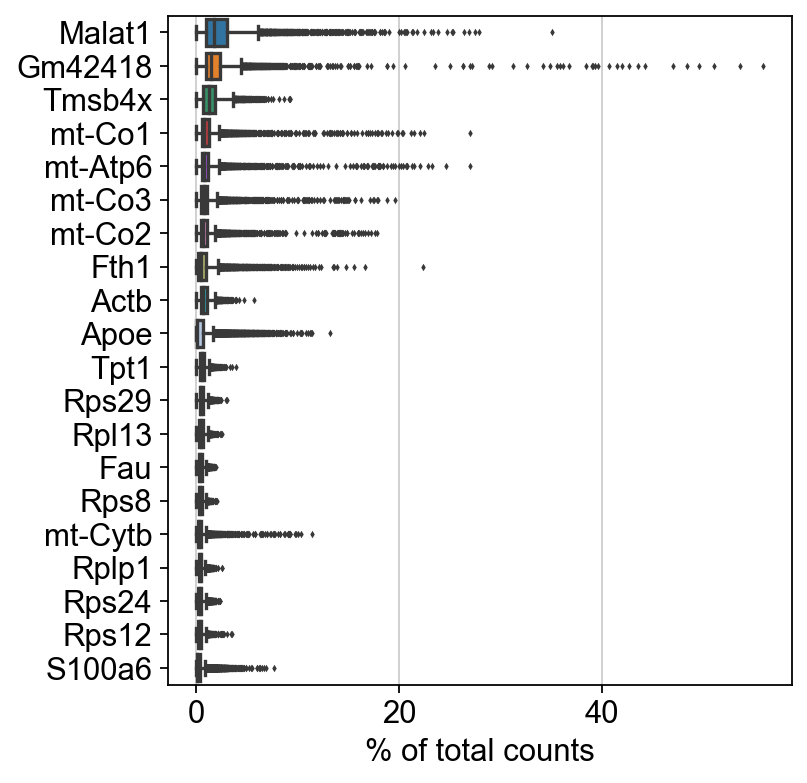

In [8]:
## Preprocessing
sc.pl.highest_expr_genes(adata, n_top=20, )

In [9]:
# Filtering genes (like how it is done in DESeq2)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 57 cells that have less than 200 genes expressed
filtered out 12923 genes that are detected in less than 3 cells


In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

In [11]:
adata.var

,gene_ids,feature_types,genome,n_cells,mt
Xkr4,ENSMUSG00000051951,Gene Expression,mm10-YFP,9,False
Gm19938,ENSMUSG00000102331,Gene Expression,mm10-YFP,3,False
Sox17,ENSMUSG00000025902,Gene Expression,mm10-YFP,186,False
Mrpl15,ENSMUSG00000033845,Gene Expression,mm10-YFP,3781,False
Lypla1,ENSMUSG00000025903,Gene Expression,mm10-YFP,2442,False
...,...,...,...,...,...
Spry3,ENSMUSG00000061654,Gene Expression,mm10-YFP,8,False
Tmlhe,ENSMUSG00000079834,Gene Expression,mm10-YFP,92,False
CAAA01147332.1,ENSMUSG00000095742,Gene Expression,mm10-YFP,180,False
AC149090.1,ENSMUSG00000095041,Gene Expression,mm10-YFP,6313,False


In [12]:
adata.var[adata.var.mt==True]

,gene_ids,feature_types,genome,n_cells,mt


In [13]:
# Adds a bunch of information 	n_genes	n_genes_by_counts	total_counts	total_counts_mt	pct_counts_mt
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [14]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCCAAGCCGATAG-1,5863,5862,34317.0,0.0,0.0
AAACCCACAGAGGACT-1,1156,1156,2340.0,0.0,0.0
AAACCCACAGTAACCT-1,2603,2603,8017.0,0.0,0.0
AAACCCACAGTGAGCA-1,1320,1320,2854.0,0.0,0.0
AAACCCACATAGATGA-1,4184,4184,15113.0,0.0,0.0
...,...,...,...,...,...
TTTGTTGCACTTCTCG-1,1747,1747,4070.0,0.0,0.0
TTTGTTGCATCCTAAG-1,2932,2931,7333.0,0.0,0.0
TTTGTTGGTATCGTAC-1,577,576,929.0,0.0,0.0
TTTGTTGGTCTGTAAC-1,901,901,1332.0,0.0,0.0


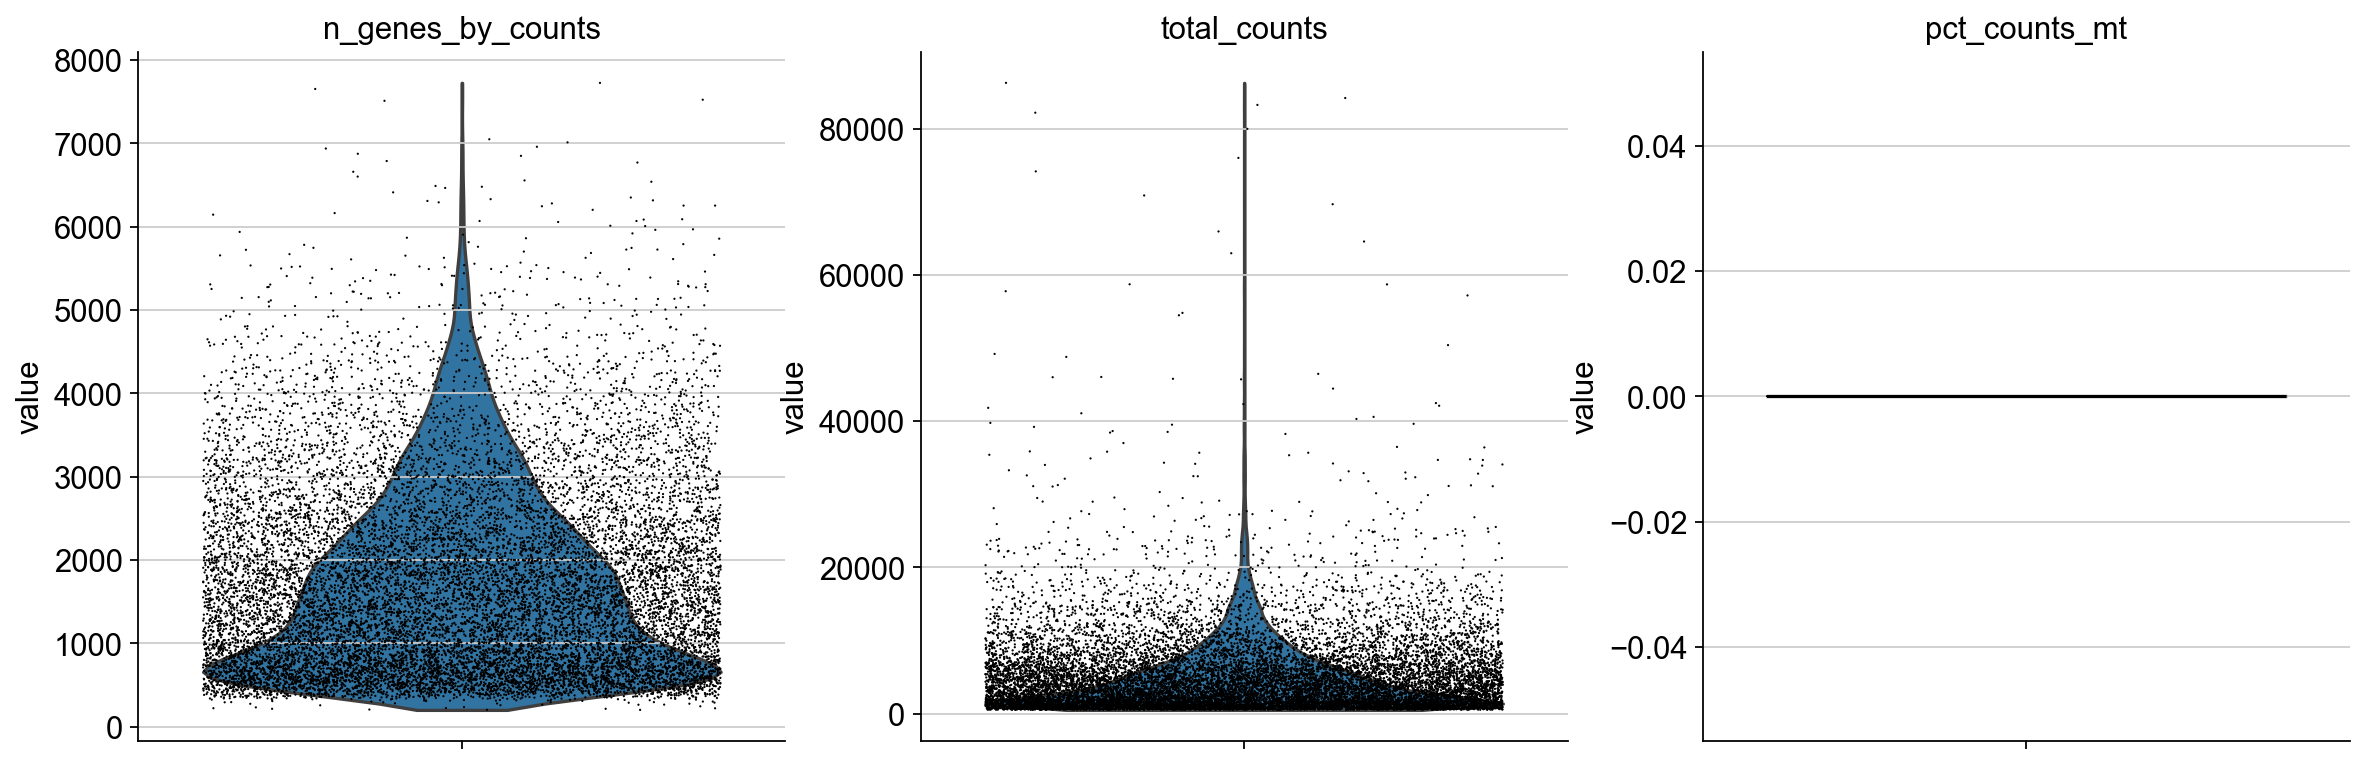

In [15]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
# 'n_genes_by_counts' (number of detected genes per cell)
#'total_counts' (total counts per cell)
#'pct_counts_mt' (percentage of counts coming from mitochondrial genes per cell).

In [51]:
#instead of picking subjectively, you can use quanitle
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
lower_lim = np.quantile(adata.obs.n_genes_by_counts.values, .02)
print(f'{lower_lim} to {upper_lim}')

393.0 to 4565.799999999999


In [16]:
adata.obs # This is a pandas dataframe and you can filter it

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCCAAGCCGATAG-1,5863,5862,34317.0,0.0,0.0
AAACCCACAGAGGACT-1,1156,1156,2340.0,0.0,0.0
AAACCCACAGTAACCT-1,2603,2603,8017.0,0.0,0.0
AAACCCACAGTGAGCA-1,1320,1320,2854.0,0.0,0.0
AAACCCACATAGATGA-1,4184,4184,15113.0,0.0,0.0
...,...,...,...,...,...
TTTGTTGCACTTCTCG-1,1747,1747,4070.0,0.0,0.0
TTTGTTGCATCCTAAG-1,2932,2931,7333.0,0.0,0.0
TTTGTTGGTATCGTAC-1,577,576,929.0,0.0,0.0
TTTGTTGGTCTGTAAC-1,901,901,1332.0,0.0,0.0


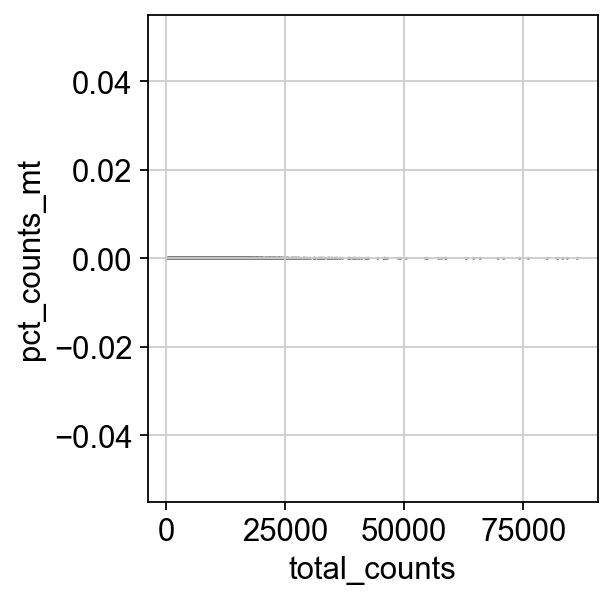

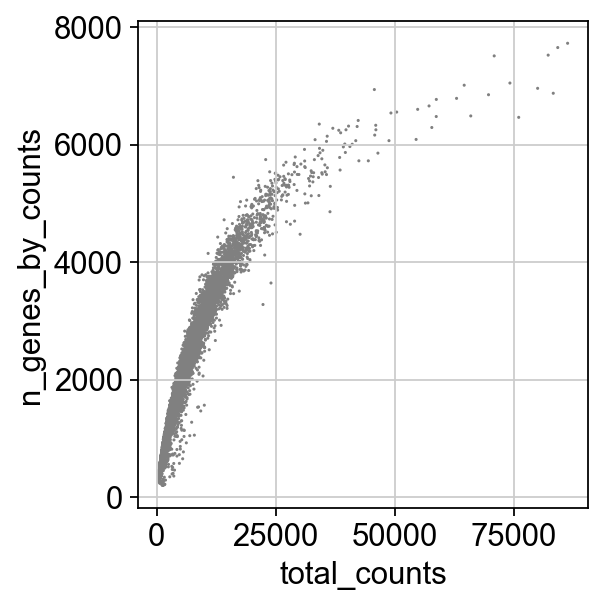

In [17]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [14]:
# To filter one of the rows
adata[adata.obs.index == 'AAACCCAAGCCGATAG-1']

View of AnnData object with n_obs × n_vars = 1 × 19363
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [89]:
adata = adata[(adata.obs.n_genes_by_counts < 3000) & (adata.obs.n_genes_by_counts > 700)]

In [80]:
adata

View of AnnData object with n_obs × n_vars = 10478 × 19363
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [100]:
adata.X[4,:].sum()

9999.968

In [101]:
sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI(Done to be able to compare cells)

normalizing counts per cell
    finished (0:00:00)


In [102]:
adata.X[4,:].sum()

9999.968

In [18]:
sc.pp.log1p(adata)

In [19]:
# Clustering
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [20]:
adata.raw = adata #save raw data before processing values and further filtering

In [21]:
adata = adata[:, adata.var.highly_variable] #filter highly variable

In [22]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) #Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:20)


In [23]:
sc.pp.scale(adata, max_value=10) #scale each gene to unit variance


In [24]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


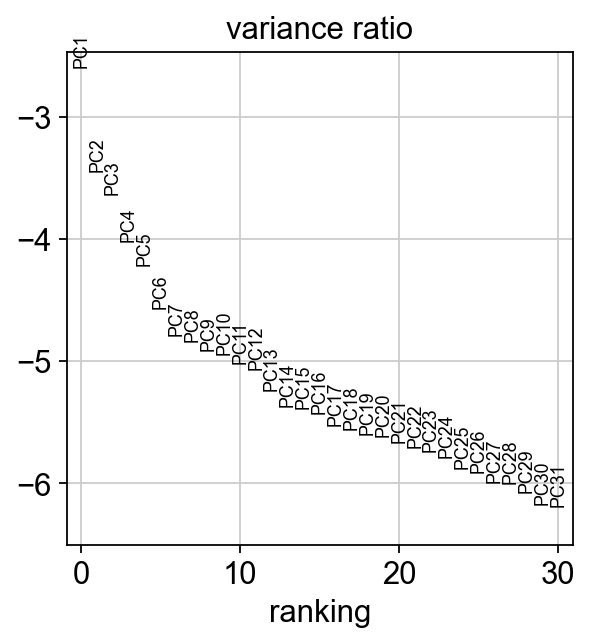

In [25]:
sc.pl.pca_variance_ratio(adata, log=True)

In [26]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)

computing neighbors
    using 'X_pca' with n_pcs = 20


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)


In [27]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


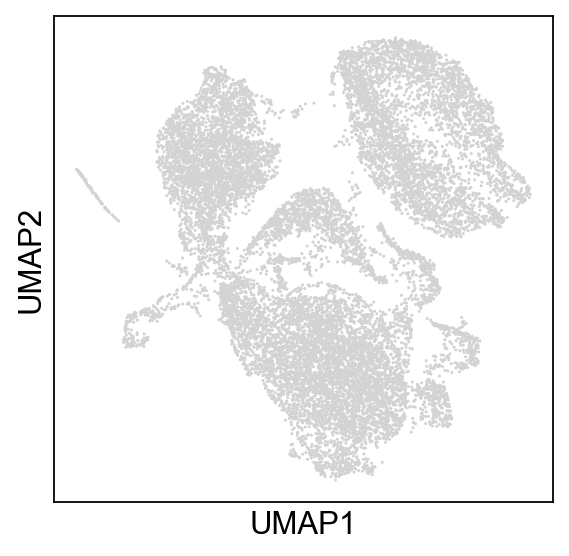

In [28]:
sc.pl.umap(adata)

running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)


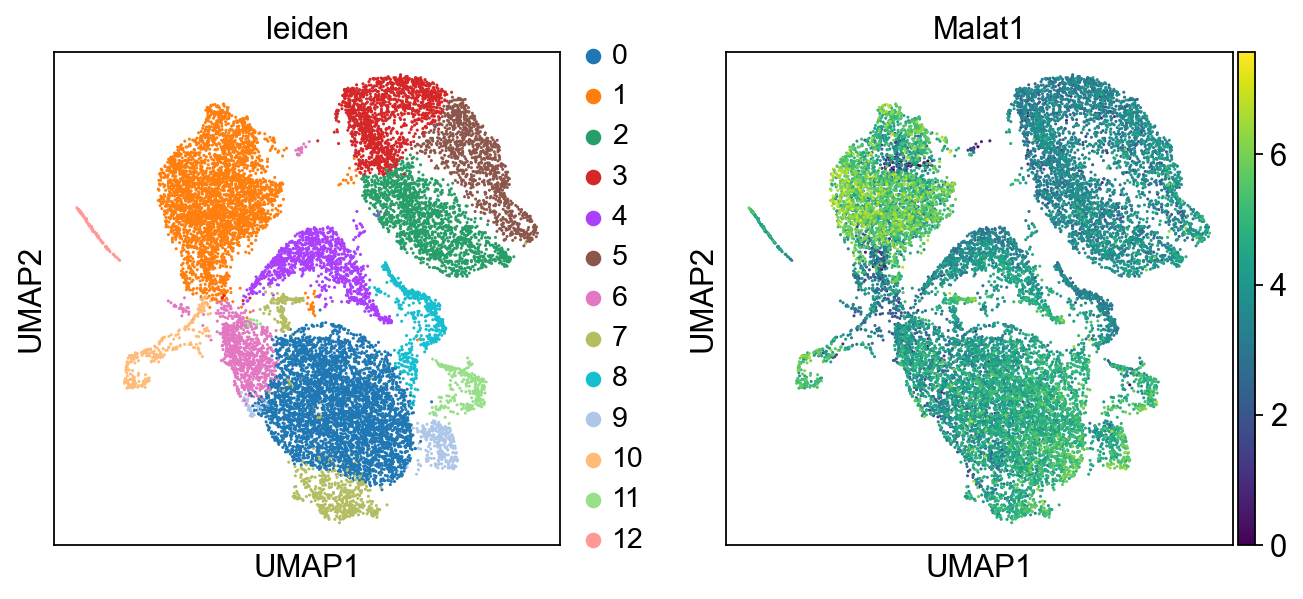

In [39]:
sc.tl.leiden(adata, resolution = 0.25)
# Selecting genes that have significance with the dataset
sc.pl.umap(adata, color=['leiden','Malat1'])

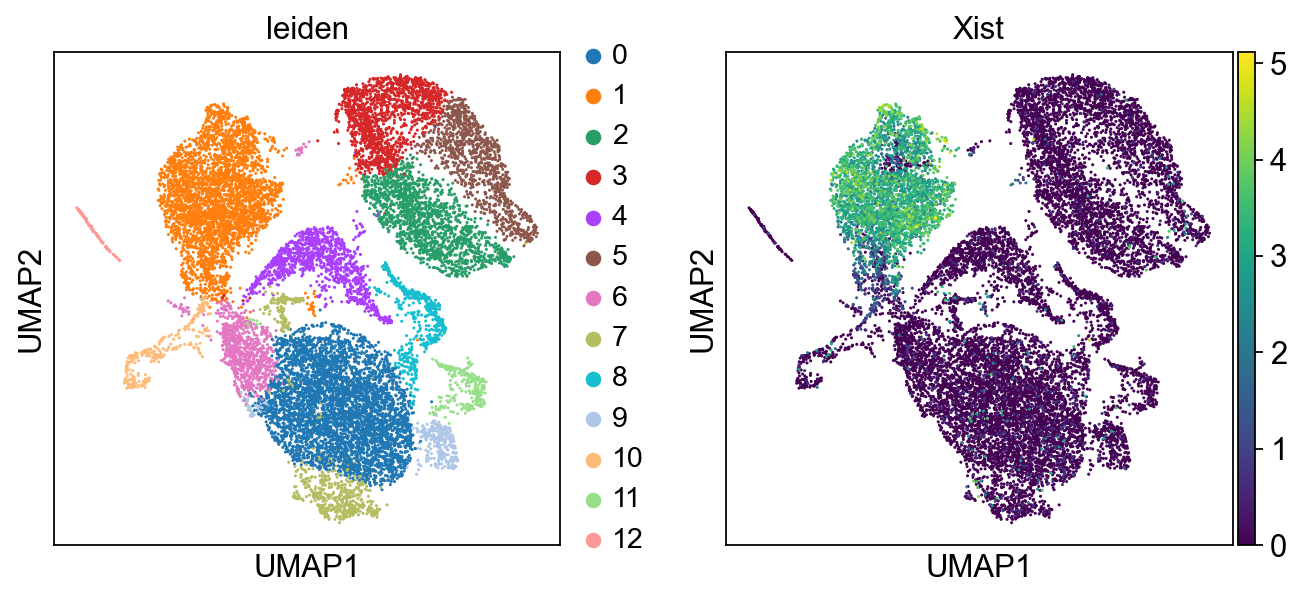

In [41]:
sc.pl.umap(adata, color=['leiden','Xist'])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:23)


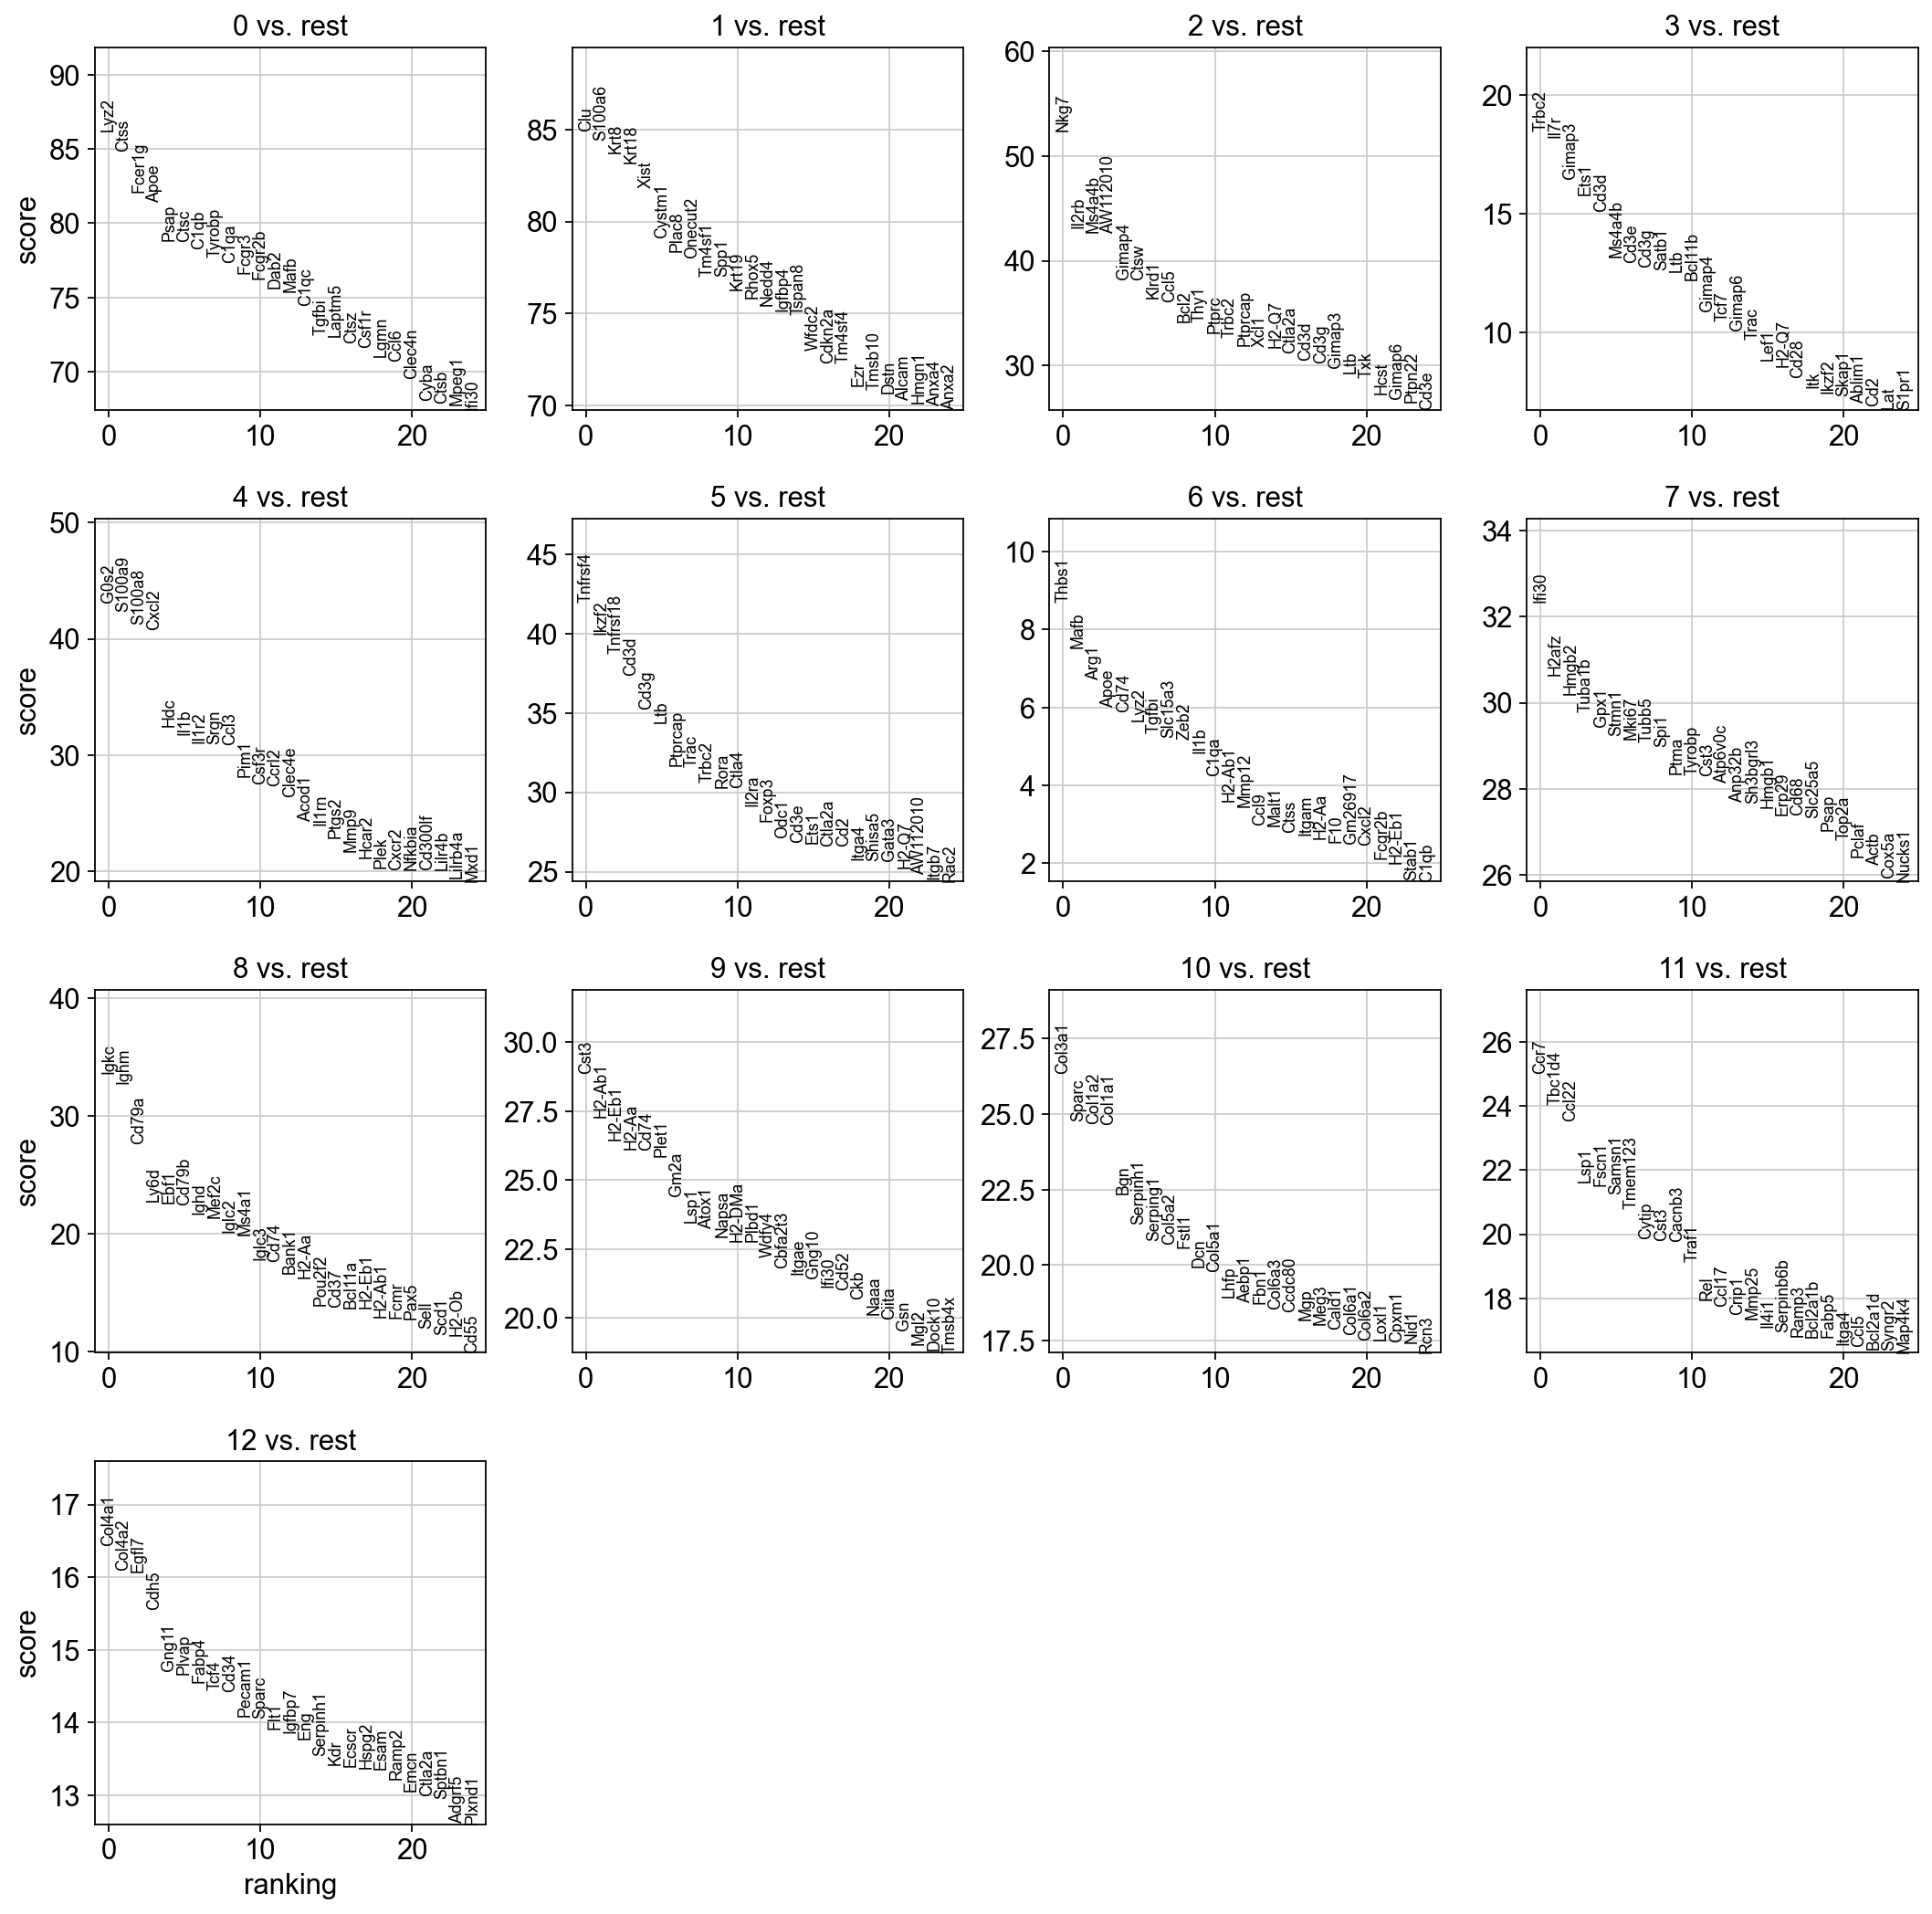

In [36]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)